# 나이브 베이스 분류기(Naive Bayes Classification)

* 베이즈 정리를 적용한 확률적 분류 알고리즘
* 모든 특성들이 독립임을 가정 (naive 가정)
* 입력 특성에 따라 3개의 분류기 존재
  * 가우시안 나이브 베이즈 분류기
  * 베르누이 나이브 베이즈 분류기
  * 다항 나이브 베이즈 분류기

## 나이브 베이즈 분류기의 확률 모델

* 나이브 베이즈는 조건부 확률 모델
* *N*개의 특성을 나타내는 벡터 **x**를 입력 받아 k개의 가능한 확률적 결과를 출력

\begin{equation}
p(C_k | x_1,...,x_n)
\end{equation}

* 위의 식에 베이즈 정리를 적용하면 다음과 같음

\begin{equation}
p(C_k | \textbf{x}) = \frac{p(C_k)p(\textbf{x}|C_k)}{p(\textbf{x})}
\end{equation}

* 위의 식에서 분자만이 출력 값에 영향을 받기 때문에 분모 부분을 상수로 취급할 수 있음

\begin{equation}
\begin{split}
p(C_k | \textbf{x}) & \propto p(C_k)p(\textbf{x}|C_k) \\
& \propto p(C_k, x_1, ..., x_n)
\end{split}
\end{equation}

* 위의 식을 연쇄 법칙을 사용해 다음과 같이 쓸 수 있음

\begin{equation}
\begin{split}
p(C_k, x_1, ..., x_n) & = p(C_k)p(x_1, ..., x_n | C_k) \\
& = p(C_k)p(x_1 | C_k)p(x_2, ..., x_n | C_k, x_1) \\
& = p(C_k)p(x_1 | C_k)p(x_2 | C_k, x_1)p(x_3, ..., x_n | C_k, x_1, x_2) \\
& = p(C_k)p(x_1 | C_k)p(x_2 | C_k, x_1)...p(x_n | C_k, x_1, x_2, ..., x_{n-1})
\end{split}
\end{equation}

* 나이브 베이즈 분류기는 모든 특성이 독립이라고 가정하기 때문에 위의 식을 다음과 같이 쓸 수 있음

\begin{equation}
\begin{split}
p(C_k, x_1, ..., x_n) & \propto p(C_k)p(x_1|C_k)p(x_2|C_k)...p(x_n|C_k) \\
& \propto p(C_k) \prod_{i=1}^{n} p(x_i|C_k)
\end{split}
\end{equation}

* 위의 식을 통해 나온 값들 중 가장 큰 값을 갖는 클래스가 예측 결과

\begin{equation}
\hat{y} = \underset{k}{\arg\max} \; p(C_k) \prod_{i=1}^{n} p(x_i|C_k)
\end{equation}

In [126]:
import numpy as np
import pandas as pd

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.datasets import fetch_covtype, fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn import metrics

In [3]:
prior = [0.45, 0.3, 0.15,0.1]
likelihood = [[0.3, 0.3, 0.4], [0.7, 0.2, 0.1], [0.15, 0.5, 0.35], [0.6, 0.2, 0.2]]

idx=0
for c, xs in zip(prior, likelihood):
    result = 1.
    
    for x in xs:
        result *= x
    result *= c
    
    idx += 1
    print(f'{idx}번째 클래스의 가능성: {result}')
    

1번째 클래스의 가능성: 0.0162
2번째 클래스의 가능성: 0.0042
3번째 클래스의 가능성: 0.0039375
4번째 클래스의 가능성: 0.0024000000000000002


## 산림 토양 데이터
* 산림 지역 토양의 특징 데이터
* 토양이 어떤 종류에 속하는지 예측
* https://archive.ics.uci.edu/ml/datasets/Covertype 에서 데이터의 자세한 설명 확인 가능

In [7]:
covtype = fetch_covtype()
print(covtype.DESCR)

.. _covtype_dataset:

Forest covertypes
-----------------

The samples in this dataset correspond to 30×30m patches of forest in the US,
collected for the task of predicting each patch's cover type,
i.e. the dominant species of tree.
There are seven covertypes, making this a multiclass classification problem.
Each sample has 54 features, described on the
`dataset's homepage <https://archive.ics.uci.edu/ml/datasets/Covertype>`__.
Some of the features are boolean indicators,
while others are discrete or continuous measurements.

**Data Set Characteristics:**

    =================   ============
    Classes                        7
    Samples total             581012
    Dimensionality                54
    Features                     int
    =================   ============

:func:`sklearn.datasets.fetch_covtype` will load the covertype dataset;
it returns a dictionary-like 'Bunch' object
with the feature matrix in the ``data`` member
and the target values in ``target``. If optional a

In [6]:
covtype.data

array([[2.596e+03, 5.100e+01, 3.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.590e+03, 5.600e+01, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.804e+03, 1.390e+02, 9.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [2.386e+03, 1.590e+02, 1.700e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.384e+03, 1.700e+02, 1.500e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.383e+03, 1.650e+02, 1.300e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [8]:
pd.DataFrame(covtype.data) #현재 피쳐가 뭔지 모름

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396.0,153.0,20.0,85.0,17.0,108.0,240.0,237.0,118.0,837.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581008,2391.0,152.0,19.0,67.0,12.0,95.0,240.0,237.0,119.0,845.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581009,2386.0,159.0,17.0,60.0,7.0,90.0,236.0,241.0,130.0,854.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581010,2384.0,170.0,15.0,60.0,5.0,90.0,230.0,245.0,143.0,864.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
covtype.target

array([5, 5, 2, ..., 3, 3, 3])

### 학습, 평가 데이터 분류

In [60]:
covtype_X = covtype.data
covtype_y = covtype.target

In [61]:
covtype_X_train, covtype_X_test, covtype_y_train, covtype_y_test = train_test_split(covtype_X, covtype_y, test_size=0.2)

In [12]:
print(f'전체 데이터 크기 : {covtype_X.shape}')
print(f'학습 데이터 크기 : {covtype_X_train.shape}')
print(f'평가 데이터 크기 : {covtype_X_test.shape}')

전체 데이터 크기 : (581012, 54)
학습 데이터 크기 : (464809, 54)
평가 데이터 크기 : (116203, 54)


### 전처리

#### 전처리 전 데이터

In [17]:
covtype_df = pd.DataFrame(data = covtype_X)
covtype_df.describe() #count를 보면서 데이터의 갯수 파악

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.044175,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.205483,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
covtype_train_df = pd.DataFrame(data=covtype_X_train)
covtype_train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,464809.00000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,...,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000
mean,2959.56892,155.739581,14.095809,269.531689,46.453855,2349.166286,212.149367,223.336295,142.550555,1979.230148,...,0.044199,0.090377,0.077845,0.002816,0.003249,0.000207,0.000516,0.026888,0.023904,0.014963
std,279.93603,111.912774,7.481740,212.680693,58.282806,1558.677039,26.741988,19.752355,38.259072,1323.195135,...,0.205537,0.286721,0.267928,0.052993,0.056904,0.014370,0.022717,0.161758,0.152752,0.121405
min,1861.00000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2810.00000,58.000000,9.000000,108.000000,7.000000,1104.000000,198.000000,213.000000,119.000000,1022.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.00000,127.000000,13.000000,218.000000,30.000000,1996.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3164.00000,261.000000,18.000000,390.000000,69.000000,3327.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3858.00000,360.000000,66.000000,1397.000000,598.000000,7117.000000,254.000000,254.000000,254.000000,7172.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
covtype_test_df = pd.DataFrame(data=covtype_X_test)
covtype_test_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,...,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000
mean,2958.550829,155.325714,14.135281,269.014328,46.278857,2354.067890,212.132776,223.248402,142.439094,1984.535511,...,0.044078,0.090454,0.077201,0.002599,0.003279,0.000198,0.000499,0.026462,0.023192,0.015447
std,280.179193,111.917378,7.514141,212.023602,58.344949,1561.564602,26.881314,19.833859,38.336332,1328.185182,...,0.205269,0.286832,0.266911,0.050913,0.057167,0.014067,0.022336,0.160506,0.150514,0.123323
min,1859.000000,0.000000,0.000000,0.000000,-166.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2807.000000,58.000000,9.000000,108.000000,7.000000,1110.000000,198.000000,213.000000,119.000000,1026.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2995.000000,126.000000,13.000000,218.000000,29.000000,1999.000000,218.000000,226.000000,143.000000,1707.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3162.000000,260.000000,18.000000,384.000000,69.000000,3331.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3852.000000,360.000000,65.000000,1390.000000,601.000000,7092.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 전처리 과정

In [20]:
scaler = StandardScaler()
covtype_X_train_scale = scaler.fit_transform(covtype_X_train)
covtype_X_test_scale = scaler.transform(covtype_X_test)

##### 전처리 과정 중 처음에는 fit_transform을 쓰고 다음에는 transform만 쓰는 이유

1) fit_transform 은
- scaler.fit(x_train)
- scaled_x_train = scaler.transform(x_train) 이 과정을 한 줄로 줄여쓴 것이다
따라서 scaled_x_train = fit_transform(x_train)이 되는 것이다

2) 그렇기 때문에 이미 scaler.fit(x_train)이 어디 변수에 저장되어 진게 아니라 이미 fit 된 상태로 존재하기 때문에
다음에 쓸때에는 transform(x_test)만 쓰게 되는 것이다

3) 근데 왜 x_train을 fit한 기준을 x_test에도 쓰는 것이냐면, 훈련 데이터에서 scale한 기반과 똑같은 기준으로
test에도 해주어야 동일하게 비교가 가능하기 때문이다


#### 전처리 후 데이터
* 평균은 0에 가깝게, 표준평차는 1에 가깝게 정규화

In [22]:
covtype_train_df = pd.DataFrame(data=covtype_X_train_scale) #scale을 통해서 데이터의 분포를 축약시킴 (정규화)
covtype_train_df.describe() #훈련데이터의 정규화

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,...,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05
mean,7.648968e-16,1.122268e-16,3.625114e-17,-1.605785e-16,-3.740321e-16,1.128764e-16,-4.541441e-16,4.014375e-16,4.194809e-16,5.941179e-17,...,1.975443e-15,2.641996e-15,7.358777e-15,3.293714e-15,-2.214113e-15,6.791937e-15,9.827139e-16,8.560143e-15,7.481047e-16,-7.214042e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-3.924361e+00,-1.391617e+00,-1.884030e+00,-1.267308e+00,-3.765332e+00,-1.507156e+00,-7.933202e+00,-1.130683e+01,-3.725932e+00,-1.495798e+00,...,-2.150411e-01,-3.152086e-01,-2.905447e-01,-5.314286e-02,-5.708970e-02,-1.437286e-02,-2.272901e-02,-1.662270e-01,-1.564924e-01,-1.232495e-01
25%,-5.342974e-01,-8.733559e-01,-6.811002e-01,-7.595041e-01,-6.769389e-01,-7.988619e-01,-5.291073e-01,-5.232949e-01,-6.155555e-01,-7.234240e-01,...,-2.150411e-01,-3.152086e-01,-2.905447e-01,-5.314286e-02,-5.708970e-02,-1.437286e-02,-2.272901e-02,-1.662270e-01,-1.564924e-01,-1.232495e-01
50%,1.301409e-01,-2.568037e-01,-1.464646e-01,-2.422963e-01,-2.823109e-01,-2.265810e-01,2.187810e-01,1.348552e-01,1.174742e-02,-2.034699e-01,...,-2.150411e-01,-3.152086e-01,-2.905447e-01,-5.314286e-02,-5.708970e-02,-1.437286e-02,-2.272901e-02,-1.662270e-01,-1.564924e-01,-1.232495e-01
75%,7.302786e-01,9.405587e-01,5.218298e-01,5.664287e-01,3.868408e-01,6.273492e-01,7.049085e-01,6.917514e-01,6.651879e-01,4.313577e-01,...,-2.150411e-01,-3.152086e-01,-2.905447e-01,-5.314286e-02,-5.708970e-02,-1.437286e-02,-2.272901e-02,-1.662270e-01,-1.564924e-01,-1.232495e-01
max,3.209419e+00,1.825177e+00,6.937456e+00,5.301231e+00,9.463284e+00,3.058901e+00,1.564980e+00,1.552409e+00,2.913023e+00,3.924422e+00,...,4.650274e+00,3.172503e+00,3.441811e+00,1.881720e+01,1.751629e+01,6.957557e+01,4.399664e+01,6.015868e+00,6.390088e+00,8.113625e+00


In [24]:
covtype_test_df = pd.DataFrame(data=covtype_X_test_scale) #scale을 통해서 데이터의 분포를 축약시킴 (정규화)
covtype_test_df.describe() #test데이터의 정규화

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,...,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000
mean,-0.003637,-0.003698,0.005276,-0.002433,-0.003003,0.003145,-0.000620,-0.004450,-0.002913,0.004010,...,-0.000588,0.000268,-0.002403,-0.004101,0.000529,-0.000599,-0.000758,-0.002635,-0.004663,0.003986
std,1.000870,1.000042,1.004332,0.996912,1.001067,1.001854,1.005211,1.004127,1.002020,1.003772,...,0.998700,1.000387,0.996208,0.960752,1.004611,0.978950,0.983202,0.992265,0.985353,1.015798
min,-3.931506,-1.391617,-1.884030,-1.267308,-3.645227,-1.507156,-7.933202,-11.306831,-3.725932,-1.495798,...,-0.215041,-0.315209,-0.290545,-0.053143,-0.057090,-0.014373,-0.022729,-0.166227,-0.156492,-0.123249
25%,-0.545014,-0.873356,-0.681100,-0.759504,-0.676939,-0.795012,-0.529107,-0.523295,-0.615555,-0.720401,...,-0.215041,-0.315209,-0.290545,-0.053143,-0.057090,-0.014373,-0.022729,-0.166227,-0.156492,-0.123249
50%,0.126569,-0.265739,-0.146465,-0.242296,-0.299469,-0.224656,0.218781,0.134855,0.011747,-0.205737,...,-0.215041,-0.315209,-0.290545,-0.053143,-0.057090,-0.014373,-0.022729,-0.166227,-0.156492,-0.123249
75%,0.723134,0.931623,0.521830,0.538217,0.386841,0.629915,0.704908,0.691751,0.665188,0.431358,...,-0.215041,-0.315209,-0.290545,-0.053143,-0.057090,-0.014373,-0.022729,-0.166227,-0.156492,-0.123249
max,3.187986,1.825177,6.803797,5.268318,9.514757,3.042862,1.564980,1.552409,2.913023,3.925177,...,4.650274,3.172503,3.441811,18.817202,17.516293,69.575573,43.996638,6.015868,6.390088,8.113625


## 20 Newsgroup 데이터
* 뉴스 기사가 어느 그룹에 속하는지 분류
* 뉴스 기사는 텍스트 데이터이기 때문에 특별한 전처리 과정이 필요

In [26]:
newsgroup = fetch_20newsgroups()
print(newsgroup.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

In [27]:
newsgroup.data

["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
 "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 

In [29]:
pd.DataFrame(newsgroup.data)

,0
0,From: lerxst@wam.umd.edu (where's my thing)\nS...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...
...,...
11309,From: jim.zisfein@factory.com (Jim Zisfein) \n...
11310,From: ebodin@pearl.tufts.edu\nSubject: Screen ...
11311,From: westes@netcom.com (Will Estes)\nSubject:...
11312,From: steve@hcrlgw (Steven Collins)\nSubject: ...


In [31]:
newsgroup.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### 학습, 평가 데이터 분류

In [32]:
newsgroup_train = fetch_20newsgroups(subset='train')
newsgroup_test = fetch_20newsgroups(subset='test')

In [33]:
X_train, y_train = newsgroup_train.data, newsgroup_train.target
X_test, y_test = newsgroup_test.data, newsgroup_test.target

### 벡터화
* 텍스트 데이터는 기계학습 모델에 입력 할 수 없음
* 벡터화는 텍스트 데이터를 실수 벡터로 변환해 기계학습 모델에 입력 할 수 있도록 하는 전처리 과정
* Scikit-learn에서는 Count, Tf-idf, Hashing 세가지 방법을 지원

#### CountVectorizer
* 문서에 나온 단어의 수를 세서 벡터 생성

In [34]:
count_vectorize = CountVectorizer()

In [35]:
X_train_count = count_vectorize.fit_transform(X_train)
X_test_count = count_vectorize.transform(X_test)

데이터를 희소 행렬 형태로 표현

In [36]:
X_train_count

<11314x130107 sparse matrix of type '<class 'numpy.int64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

In [37]:
for v in X_train_count[0]:
    print(v)

  (0, 56979)	3
  (0, 75358)	2
  (0, 123162)	2
  (0, 118280)	2
  (0, 50527)	2
  (0, 124031)	2
  (0, 85354)	1
  (0, 114688)	1
  (0, 111322)	1
  (0, 123984)	1
  (0, 37780)	5
  (0, 68532)	3
  (0, 114731)	5
  (0, 87620)	1
  (0, 95162)	1
  (0, 64095)	1
  (0, 98949)	1
  (0, 90379)	1
  (0, 118983)	1
  (0, 89362)	3
  (0, 79666)	1
  (0, 40998)	1
  (0, 92081)	1
  (0, 76032)	1
  (0, 4605)	1
  :	:
  (0, 37565)	1
  (0, 113986)	1
  (0, 83256)	1
  (0, 86001)	1
  (0, 51730)	1
  (0, 109271)	1
  (0, 128026)	1
  (0, 96144)	1
  (0, 78784)	1
  (0, 63363)	1
  (0, 90252)	1
  (0, 123989)	1
  (0, 67156)	1
  (0, 128402)	2
  (0, 62221)	1
  (0, 57308)	1
  (0, 76722)	1
  (0, 94362)	1
  (0, 78955)	1
  (0, 114428)	1
  (0, 66098)	1
  (0, 35187)	1
  (0, 35983)	1
  (0, 128420)	1
  (0, 86580)	1


#### HashingVectorizer
* 각 단어를 해쉬 값으로 표현
* 미리 정해진 크기의 벡터로 표현

In [41]:
hash_vectorizer = HashingVectorizer(n_features=1000)

In [43]:
X_train_hash = hash_vectorizer.fit_transform(X_train)
X_test_hash = hash_vectorizer.transform(X_test)

In [45]:
X_train_hash

<11314x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1550687 stored elements in Compressed Sparse Row format>

In [46]:
print(X_train_hash[0])

  (0, 80)	-0.0642824346533225
  (0, 108)	0.0642824346533225
  (0, 111)	-0.128564869306645
  (0, 145)	0.0642824346533225
  (0, 158)	0.0642824346533225
  (0, 159)	-0.0642824346533225
  (0, 161)	0.0642824346533225
  (0, 165)	-0.0642824346533225
  (0, 171)	0.0642824346533225
  (0, 182)	0.0642824346533225
  (0, 195)	-0.0642824346533225
  (0, 196)	0.19284730395996752
  (0, 205)	-0.0642824346533225
  (0, 209)	0.0642824346533225
  (0, 234)	0.0642824346533225
  (0, 237)	0.0642824346533225
  (0, 248)	0.0642824346533225
  (0, 265)	0.19284730395996752
  (0, 274)	0.0642824346533225
  (0, 277)	0.19284730395996752
  (0, 284)	-0.0642824346533225
  (0, 286)	-0.0642824346533225
  (0, 296)	0.0642824346533225
  (0, 362)	-0.0642824346533225
  (0, 364)	-0.0642824346533225
  :	:
  (0, 739)	0.0
  (0, 761)	-0.0642824346533225
  (0, 766)	0.0642824346533225
  (0, 800)	-0.0642824346533225
  (0, 812)	-0.0642824346533225
  (0, 842)	0.0642824346533225
  (0, 848)	-0.0642824346533225
  (0, 851)	0.0642824346533225
  (0

#### TfidfVectorizer
* 문서에 나온 단어 빈도(term frequency)와 역문서 빈도(inverse document frequency)를 곱해서 구함
* 각 빈도는 일반적으로 로그 스케일링 후 사용
* $tf(t, d) = log(f(t, d) + 1)$
* $idf(t, D) = \frac{|D|}{|d \in D : t \in d| + 1}$
* $tfidf(t, d, D) = tf(t, d) \times idf(t, D)$

In [47]:
tfidf_vectorizer = TfidfVectorizer()

In [48]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [49]:
X_train_tfidf

<11314x130107 sparse matrix of type '<class 'numpy.float64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

In [53]:
for v in X_train_tfidf[0]:
    print(v)

  (0, 86580)	0.13157118714240987
  (0, 128420)	0.04278499079283093
  (0, 35983)	0.03770448563619875
  (0, 35187)	0.09353930598317124
  (0, 66098)	0.09785515708314481
  (0, 114428)	0.05511105154696676
  (0, 78955)	0.05989856888061599
  (0, 94362)	0.055457031390147224
  (0, 76722)	0.06908779999621749
  (0, 57308)	0.1558717009157704
  (0, 62221)	0.02921527992427867
  (0, 128402)	0.05922294083277842
  (0, 67156)	0.07313443922740179
  (0, 123989)	0.08207027465330353
  (0, 90252)	0.031889368795417566
  (0, 63363)	0.08342748387969037
  (0, 78784)	0.0633940918806495
  (0, 96144)	0.10826904490745741
  (0, 128026)	0.060622095889758885
  (0, 109271)	0.10844724822064673
  (0, 51730)	0.09714744057976722
  (0, 86001)	0.07000411445838192
  (0, 83256)	0.08844382496462173
  (0, 113986)	0.17691750674853082
  (0, 37565)	0.03431760442478462
  :	:
  (0, 4605)	0.06332603952480323
  (0, 76032)	0.019219463052223086
  (0, 92081)	0.09913274493911223
  (0, 40998)	0.0780136819691811
  (0, 79666)	0.109364012524142

## 가우시안 나이브 베이즈

* 입력 특성이 가우시안(정규) 분포를 갖는다고 가정

In [54]:
model = GaussianNB()
model.fit(covtype_X_train_scale, covtype_y_train)

GaussianNB()

In [57]:
predict = model.predict(covtype_X_train_scale)
acc = metrics.accuracy_score(covtype_y_train, predict)
f1 = metrics.f1_score(covtype_y_train, predict, average=None)

print(f'Train 정확도 : {acc}')
print(f'Train f1 score : {f1}')

정확도 : 0.08833520865559832
f1 score : [0.04027216 0.01814108 0.33560713 0.14009176 0.04358807 0.0746613
 0.23551344]


In [62]:
predict = model.predict(covtype_X_test_scale)
acc = metrics.accuracy_score(covtype_y_test, predict)
f1 = metrics.f1_score(covtype_y_test, predict, average=None)

print(f'Test 정확도 : {acc}')
print(f'Test f1 score : {f1}')

Test 정확도 : 0.04618641515279296
Test f1 score : [0.09752897 0.00962444 0.0719706  0.009846   0.03256078 0.01134752
 0.06113564]


In [63]:
#시각화
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [64]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min()-1, x.max()+1
    y_min, y_max = y.min()-1, y.max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    
    return out

In [72]:
X, y = make_blobs(n_samples=1000) #시각화는 따로 안함 데이터양 존나 많아서 터짐

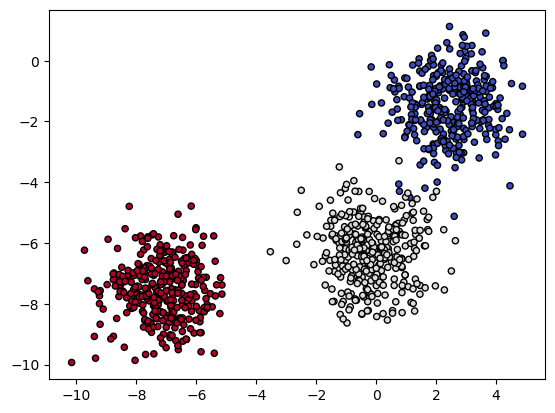

In [73]:
plt.scatter(X[:,0], X[:,-1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [74]:
model = GaussianNB()
model.fit(X,y)

GaussianNB()

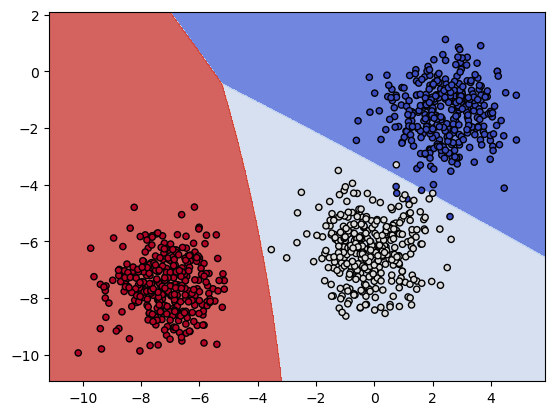

In [75]:
xx, yy = make_meshgrid(X[:,], X[:,1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha = 0.8)
plt.scatter(X[:,0], X[:,-1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

# 근데 어차피 이건 make blobs을 통해 임의로 만들어낸 1000개의 데이터 분류니깐 쉽게 나오는 것

## 베르누이 나이브 베이즈

* 입력 특성이 베르누이 분포에 의해 생성된 이진 값을 갖는 다고 가정

### 학습 및 평가 (Count)

In [76]:
model = BernoulliNB()
model.fit(X_train_count, y_train)

BernoulliNB()

In [79]:
# 베르누이 나이브 베이즈로 한 count결과 train 정확도 및 f1 score
predict = model.predict(X_train_count)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print(f'Train 정확도 : {acc}')
print(f'Train f1 score 점수 : {f1}')

Train 정확도 : 0.7821283365741559
Train f1 score 점수 : [0.80096502 0.8538398  0.13858268 0.70686337 0.85220126 0.87944493
 0.51627694 0.84532672 0.89064976 0.87179487 0.94561404 0.91331546
 0.84627832 0.89825848 0.9047619  0.79242424 0.84693878 0.84489796
 0.67329545 0.14742015]


In [80]:
# 베르누이 나이브 베이즈로 한 count결과 test 정확도 및 f1 score
predict = model.predict(X_test_count)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print(f'test 정확도 : {acc}')
print(f'test f1 score 점수 : {f1}')

test 정확도 : 0.6307753584705258
test f1 score 점수 : [0.47086247 0.60643564 0.01       0.56014047 0.6953405  0.70381232
 0.44829721 0.71878646 0.81797753 0.81893491 0.90287278 0.74794521
 0.61647059 0.64174455 0.76967096 0.63555114 0.64285714 0.77971474
 0.31382979 0.00793651]


### 학습 및 평가 (Hash)

In [116]:
model = BernoulliNB()
model.fit(X_train_hash, y_train)

BernoulliNB()

In [82]:
# 베르누이 나이브 베이즈로 한 hash결과 train 정확도 및 f1 score
predict = model.predict(X_train_hash)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print(f'Train 정확도 : {acc}')
print(f'Train f1 score 점수 : {f1}')

Train 정확도 : 0.5951917977726711
Train f1 score 점수 : [0.74226804 0.49415205 0.45039019 0.59878155 0.57327935 0.63929619
 0.35390947 0.59851301 0.72695347 0.68123862 0.79809524 0.70532319
 0.54703833 0.66862745 0.61889927 0.74707471 0.6518668  0.60485269
 0.5324165  0.54576271]


In [83]:
# 베르누이 나이브 베이즈로 한 hash결과 test 정확도 및 f1 score
predict = model.predict(X_test_hash)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print(f'test 정확도 : {acc}')
print(f'test f1 score 점수 : {f1}')

test 정확도 : 0.4430430164630908
test f1 score 점수 : [0.46678636 0.33826638 0.29391892 0.45743329 0.41939121 0.46540881
 0.34440068 0.46464646 0.62849873 0.53038674 0.63782051 0.55251799
 0.32635983 0.34266886 0.46105919 0.61780105 0.46197991 0.54591837
 0.27513228 0.3307888 ]


### 학습 및 평가 (Tf-idf)

In [84]:
model = BernoulliNB()
model.fit(X_train_tfidf, y_train)

BernoulliNB()

In [85]:
# 베르누이 나이브 베이즈로 한 thidf결과 train 정확도 및 f1 score
predict = model.predict(X_train_tfidf)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print(f'Train 정확도 : {acc}')
print(f'Train f1 score 점수 : {f1}')

Train 정확도 : 0.7821283365741559
Train f1 score 점수 : [0.80096502 0.8538398  0.13858268 0.70686337 0.85220126 0.87944493
 0.51627694 0.84532672 0.89064976 0.87179487 0.94561404 0.91331546
 0.84627832 0.89825848 0.9047619  0.79242424 0.84693878 0.84489796
 0.67329545 0.14742015]


In [86]:
# 베르누이 나이브 베이즈로 한 tfidf결과 test 정확도 및 f1 score
predict = model.predict(X_test_tfidf)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print(f'test 정확도 : {acc}')
print(f'test f1 score 점수 : {f1}')

test 정확도 : 0.6307753584705258
test f1 score 점수 : [0.47086247 0.60643564 0.01       0.56014047 0.6953405  0.70381232
 0.44829721 0.71878646 0.81797753 0.81893491 0.90287278 0.74794521
 0.61647059 0.64174455 0.76967096 0.63555114 0.64285714 0.77971474
 0.31382979 0.00793651]


### 시각화

In [89]:
#이것도 양이 좀 많아서 make_blobs로 간단하게 보자
X, y = make_blobs(n_samples=1000)
# 원래는 위의 데이터를 씀

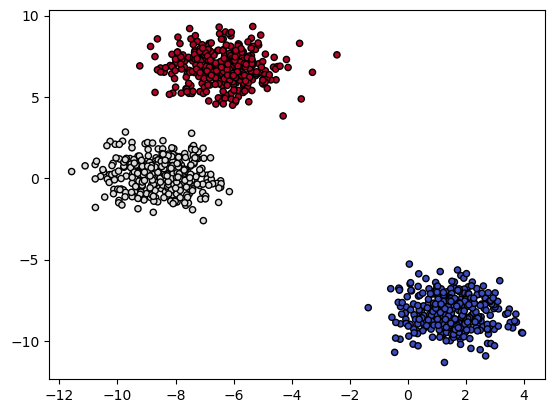

In [90]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [96]:
model = BernoulliNB()
model.fit(X, y)

'''원래는 
model = BernoulliNB()
model.fit(X_train_tfidf, y_train)
'''

'원래는 \nmodel = BernoulliNB()\nmodel.fit(X_train_tfidf, y_train)\n'

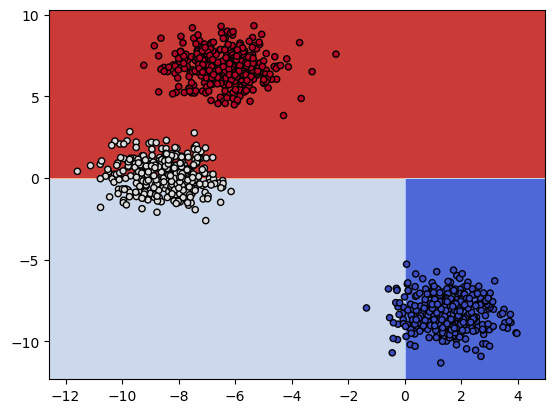

In [98]:
xx, yy = make_meshgrid(X[:,0], X[:,1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

# 구분선들이 직선으로 주욱주욱

## 다항 나이브 베이즈

* 입력 특성이 다항분포에 의해 생성된 빈도수 값을 갖는 다고 가정

### 학습 및 평가 (Count)

In [110]:
model = MultinomialNB()
model.fit(X_train_count, y_train)

MultinomialNB()

In [105]:
# 다항 나이브 베이즈를 통한 count결과 train 정확도 및 f1 score
predict = model.predict(X_train_count)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print(f'train 정확도 : {acc}')
print(f'train f1 score : {f1}')

train 정확도 : 0.9245182959165635
train f1 score : [0.95228426 0.904      0.25073746 0.81402003 0.96669513 0.88350983
 0.90710383 0.97014925 0.98567818 0.99325464 0.98423237 0.95399516
 0.95703454 0.98319328 0.98584513 0.95352564 0.97307002 0.97467249
 0.95157895 0.86526946]


In [106]:
# 다항 나이브 베이즈를 통한 count결과 test 정확도 및 f1 score
predict = model.predict(X_test_count)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print(f'test 정확도 : {acc}')
print(f'test f1 score : {f1}')

test 정확도 : 0.7728359001593202
test f1 score : [0.77901431 0.7008547  0.00501253 0.64516129 0.79178082 0.73370166
 0.76550681 0.88779285 0.93951094 0.91390728 0.94594595 0.78459938
 0.72299169 0.84635417 0.86029412 0.80846561 0.78665077 0.89281211
 0.60465116 0.48695652]


### 학습 및 평가 (Hash)

### 학습 및 평가 (Tf-idf)

In [118]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [119]:
# 다항 나이브 베이즈를 통한 tfidf결과 train 정확도 및 f1 score
predict = model.predict(X_train_count)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print(f'train 정확도 : {acc}')
print(f'train f1 score : {f1}')

train 정확도 : 0.7745271345235991
train f1 score : [0.72704403 0.74686192 0.85553471 0.81565217 0.86180422 0.84807692
 0.75619835 0.89631534 0.90860215 0.93485915 0.96464646 0.69406929
 0.75       0.84220716 0.90572687 0.43239335 0.879468   0.94982079
 0.64927536 0.10552764]


In [120]:
# 다항 나이브 베이즈를 통한 tfidf결과 test 정확도 및 f1 score
predict = model.predict(X_test_count)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print(f'test 정확도 : {acc}')
print(f'test f1 score : {f1}')

test 정확도 : 0.5679766330323951
test f1 score : [0.42009132 0.48667851 0.54700855 0.60402685 0.64205457 0.57986111
 0.64067797 0.7881137  0.82503556 0.76785714 0.88803089 0.5136612
 0.375      0.48798521 0.70238095 0.30514988 0.69230769 0.83308715
 0.35263158 0.06923077]


### 시각화

In [135]:
X, y = make_blobs(n_samples=1000)

In [136]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

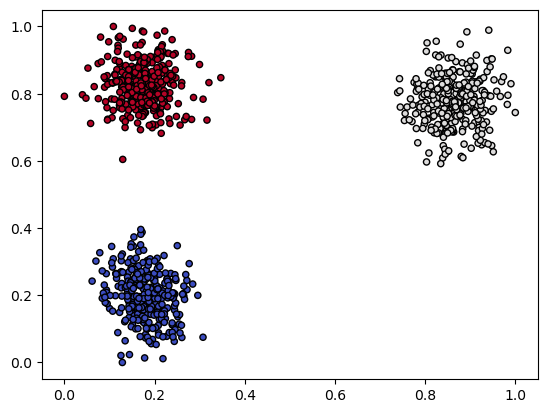

In [137]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [140]:
model = MultinomialNB()
model.fit(X,y)

MultinomialNB()

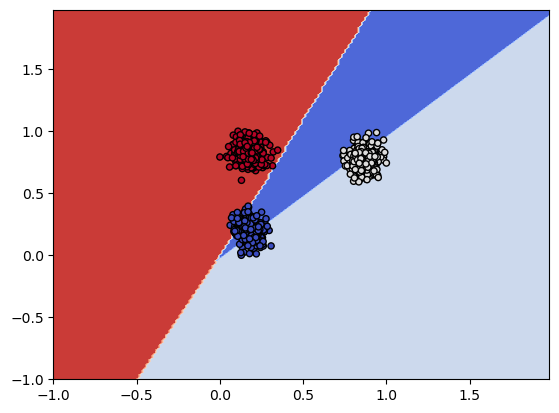

In [141]:
xx, yy = make_meshgrid(X[:,0], X[:,1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

